
# K-Means Clustering — Steps, Code, and Question Design

This notebook is a compact, practical guide to K-Means. It includes:
- Clear step-by-step instructions for implementing K-Means
- A from-scratch implementation (NumPy)
- A scikit-learn implementation
- Evaluation and model selection (inertia, elbow, silhouette)
- Preprocessing considerations (scaling, dimensionality)
- Ready-to-use exercises and question prompts you can assign or self-test with



## Step-by-step instructions (Algorithm)
1. **Choose K** (number of clusters).   Use domain knowledge or try several K values (elbow/silhouette).
2. **Initialize centroids** (randomly or with **k-means++**).
3. **Assign points** to the nearest centroid (Euclidean distance by default).
4. **Update centroids** as the mean of points assigned to each cluster.
5. **Check convergence**: stop when assignments don't change or centroid shift < tolerance, or when max iterations reached.
6. **Evaluate** using inertia (within-cluster SSE) and/or **silhouette score**; refine K and preprocessing as needed.
7. **Post-process**: label, visualize, interpret clusters, and validate with downstream tasks.



## K-Means from scratch (NumPy)
Implementation details:
- Random initialization with an option for k-means++
- Euclidean distance
- Vectorized operations where possible
- Returns labels, centroids, inertia, and number of iterations


In [1]:

import numpy as np

def _euclidean_squared(a, b):
    # a: (n_samples, n_features), b: (n_clusters, n_features)
    # returns (n_samples, n_clusters)
    a2 = np.sum(a*a, axis=1, keepdims=True)
    b2 = np.sum(b*b, axis=1)
    ab = a @ b.T
    d2 = a2 - 2*ab + b2
    return d2

def _kmeanspp_init(X, k, rng):
    n_samples = X.shape[0]
    centroids = np.empty((k, X.shape[1]), dtype=X.dtype)
    # choose first centroid uniformly
    idx0 = rng.integers(0, n_samples)
    centroids[0] = X[idx0]
    # choose remaining with prob proportional to D^2
    closest_dist_sq = _euclidean_squared(X, centroids[0:1]).ravel()
    for i in range(1, k):
        probs = closest_dist_sq / closest_dist_sq.sum()
        idx = rng.choice(n_samples, p=probs)
        centroids[i] = X[idx]
        d2 = _euclidean_squared(X, centroids[i:i+1]).ravel()
        closest_dist_sq = np.minimum(closest_dist_sq, d2)
    return centroids

def kmeans(X, k, max_iter=300, tol=1e-4, init="k-means++", random_state=None):
    X = np.asarray(X, dtype=float)
    rng = np.random.default_rng(random_state)
    if init == "k-means++":
        centroids = _kmeanspp_init(X, k, rng)
    elif init == "random":
        indices = rng.choice(X.shape[0], size=k, replace=False)
        centroids = X[indices].copy()
    else:
        raise ValueError("init must be 'k-means++' or 'random'")
    
    labels = None
    for it in range(1, max_iter+1):
        # assignment step
        d2 = _euclidean_squared(X, centroids)  # (n_samples, k)
        new_labels = np.argmin(d2, axis=1)
        # update step
        new_centroids = centroids.copy()
        for j in range(k):
            mask = new_labels == j
            if np.any(mask):
                new_centroids[j] = X[mask].mean(axis=0)
            else:
                # reinitialize empty cluster to a random point
                new_centroids[j] = X[rng.integers(0, X.shape[0])]
        # check convergence
        shift = np.sqrt(np.sum((new_centroids - centroids)**2))
        centroids = new_centroids
        if labels is not None and np.all(new_labels == labels):
            break
        if shift < tol:
            labels = new_labels
            break
        labels = new_labels
    
    inertia = float(np.sum((X - centroids[labels])**2))
    return labels, centroids, inertia, it



## Demo on synthetic data
We'll create a simple 2D dataset and run our implementation. Then, we'll visualize the clusters.


Matplotlib is building the font cache; this may take a moment.


Inertia: 418.62
Iterations: 2


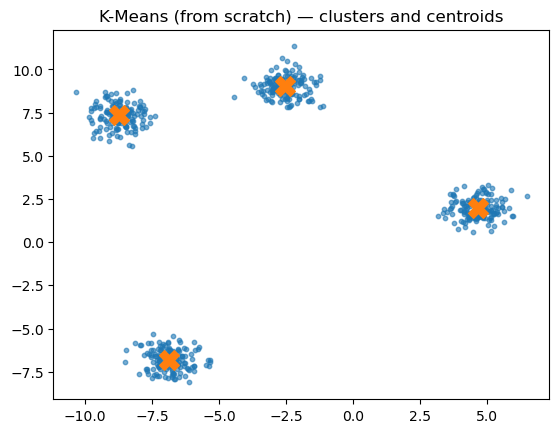

In [2]:

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

X, y_true = make_blobs(n_samples=600, centers=4, cluster_std=0.60, random_state=42)
labels, centers, inertia, iters = kmeans(X, k=4, random_state=42)

print(f"Inertia: {inertia:.2f}") 
print(f"Iterations: {iters}")

plt.figure()
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.6)
plt.scatter(centers[:,0], centers[:,1], marker='X', s=200)
plt.title("K-Means (from scratch) — clusters and centroids");



## Using scikit-learn
The `KMeans` class implements efficient k-means with options for `n_init`, `max_iter`, and `init` strategy.


Inertia: 418.6218160752002
Centroids shape: (4, 2)


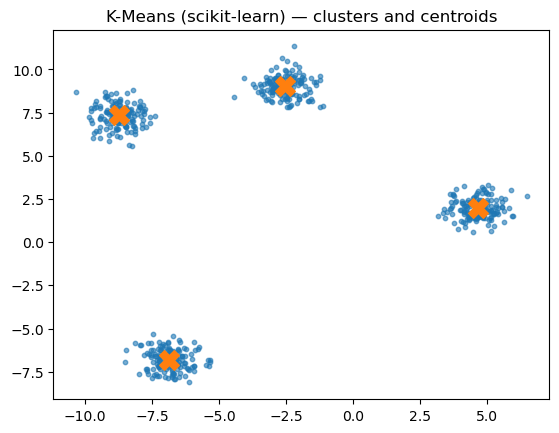

In [3]:

from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=42)
km.fit(X)
print("Inertia:", km.inertia_)
print("Centroids shape:", km.cluster_centers_.shape)
sk_labels = km.labels_
sk_centers = km.cluster_centers_

plt.figure()
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.6)
plt.scatter(sk_centers[:,0], sk_centers[:,1], marker='X', s=200)
plt.title("K-Means (scikit-learn) — clusters and centroids");



## Choosing K: Elbow method
Run k-means for several values of K and plot inertia vs. K. Look for a point where the decrease in inertia slows down (the "elbow").


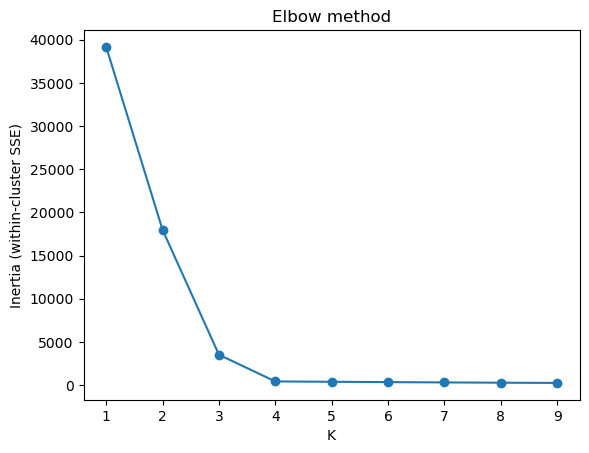

In [4]:

import numpy as np
import matplotlib.pyplot as plt

Ks = range(1, 10)
inertias = []
for k in Ks:
    km_ = KMeans(n_clusters=k, n_init=10, random_state=42)
    km_.fit(X)
    inertias.append(km_.inertia_)

plt.figure()
plt.plot(list(Ks), inertias, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia (within-cluster SSE)')
plt.title('Elbow method');



## Silhouette score
Silhouette measures how similar a point is to its own cluster vs. other clusters (range: -1 to 1). Higher is better.


Best K by silhouette: 4 (score=0.874)


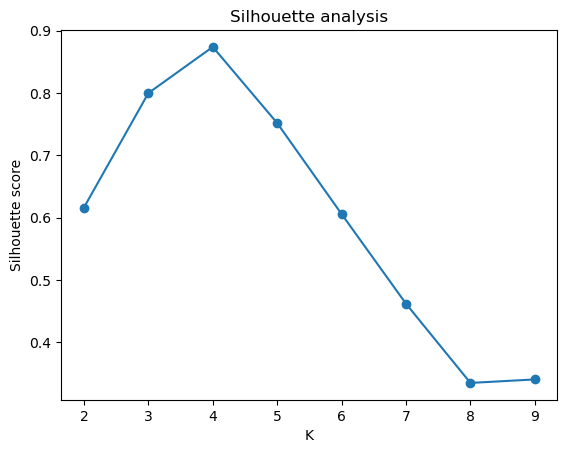

In [5]:

from sklearn.metrics import silhouette_score

best_k = None
best_sil = -1
sil_scores = []
for k in range(2, 10):
    km_ = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_ = km_.fit_predict(X)
    s = silhouette_score(X, labels_)
    sil_scores.append(s)
    if s > best_sil:
        best_sil, best_k = s, k

print(f"Best K by silhouette: {best_k} (score={best_sil:.3f})")

plt.figure()
plt.plot(range(2,10), sil_scores, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.title('Silhouette analysis');



## Preprocessing tips
- **Scale features** (e.g., `StandardScaler`) so that all dimensions contribute comparably to Euclidean distance.
- **Remove outliers** or use robust scaling if needed.
- **Dimensionality reduction** (PCA) can denoise and help visualization.
- **Categorical features**: k-means is not ideal for categorical data; consider k-modes/embeddings or a different algorithm.


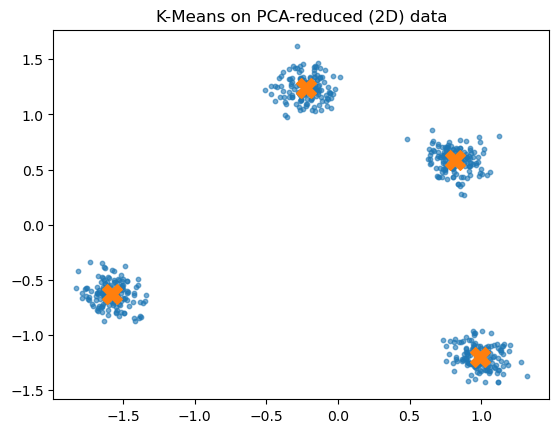

In [6]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

km_pca = KMeans(n_clusters=4, n_init=10, random_state=42)
labels_pca = km_pca.fit_predict(X_pca)

plt.figure()
plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.6)
plt.scatter(km_pca.cluster_centers_[:,0], km_pca.cluster_centers_[:,1], marker='X', s=200)
plt.title("K-Means on PCA-reduced (2D) data");



## Common pitfalls and gotchas
- **Bad initialization** can yield poor local minima → use `k-means++` and multiple `n_init`.
- **Scale sensitivity**: unscaled features dominate distance.
- **Non-globular clusters**: k-means assumes spherical-ish clusters and equal variance.
- **Unequal cluster sizes/densities**: centroid means can be misleading.
- **Empty clusters**: can occur; handle by reinitializing or using libraries that do this for you.
- **Outliers**: can drag centroids far away; consider trimming or robust alternatives (e.g., k-medoids).



## Exercises & Question Design (ready to assign)

### Conceptual (short answers)
1. Explain the difference between **inertia** and **silhouette score**. When can they disagree?
2. Why does **feature scaling** matter for k-means? Give an example where not scaling breaks clustering.
3. Compare **random initialization** vs. **k-means++**. What problem does k-means++ address?
4. Why is k-means not suitable for non-spherical clusters? Provide a counterexample dataset.
5. What are common **stopping criteria** for k-means?

### Coding (guided)
6. Implement the **assignment step** of k-means using NumPy broadcasting for efficiency.
7. Extend the from-scratch function to **return the full trace** of inertia per iteration and plot it.
8. Add a **mini-batch k-means** variant (hint: update centroids using a random subset each step).
9. Implement a **deterministic unit test** using a tiny dataset where the correct centroids are known.

### Applied (analysis)
10. Use the elbow and silhouette methods to choose K on a real dataset (e.g., Iris without labels).    Report the selected K and justify the choice with both plots and metrics.
11. Evaluate the effect of **outliers**: add 5 extreme points to your dataset. How do inertia and centroids change?
12. Compare clustering results **with vs. without scaling** on a mixed-scale dataset. Visualize and discuss.

### Debugging / Refactoring
13. Your k-means run keeps producing **empty clusters**. List three fixes and implement one.
14. Your runtime is too slow for 1e6 points. Identify the **bottleneck** and optimize one step (vectorize or mini-batch).
15. Your elbow plot has no clear elbow. Propose **three alternative strategies** to pick K and try one.

### Grading rubric idea (example)
- **Correctness (40%)**: implementation yields stable labels and reasonable inertia.
- **Methodology (25%)**: scaling, initialization, and K selection justified.
- **Clarity (20%)**: code quality, comments, and plots labeled.
- **Insight (15%)**: discussion of limitations and alternatives.



## Quick start (copy-paste)


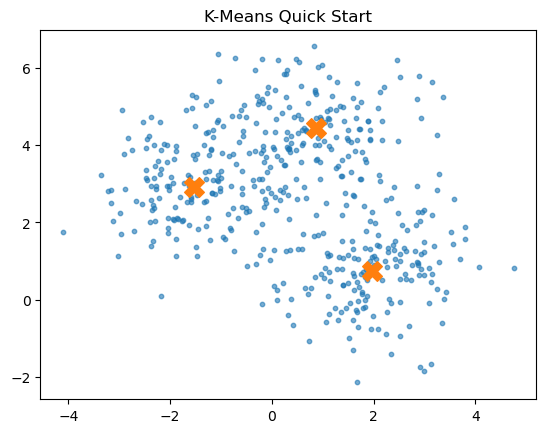

In [7]:

# Minimal runnable snippet
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

X, _ = make_blobs(n_samples=500, centers=3, random_state=0)
km = KMeans(n_clusters=3, n_init=10, random_state=0).fit(X)

plt.figure()
plt.scatter(X[:,0], X[:,1], s=10, alpha=0.6)
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker='X', s=200)
plt.title("K-Means Quick Start");


In [10]:
import importlib.util

# Load the test module dynamically
spec = importlib.util.spec_from_file_location("kmeans_unified_test", "kmeans_unified_test.py")
test_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_module)

# Run all tests
test_module.test_dataset()
test_module.test_cluster()
test_module.test_clustering()
test_module.test_invalid_k_vs_points()

print("✅ All tests passed inside Jupyter")


AttributeError: module 'kmeans' has no attribute 'Dataset'